# Introduction

As CLIP is contrastively trained against images and texts and it very good at being able to link the two. This could be highly beneficial in providing the ability to search images based on image features extracted by CLIP. This could be of particular benefit in circumstances where you had many video streams coming in for example, and you wanted to look for something specific. In this case looking through all the views could be a very cumbersome manual task.

# Import necesarry libraries

In [1]:
from glob import glob

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Load CLIP

In [2]:
from clip import clip

model, preprocess_img = clip.load('ViT-B/32')

# Load Images

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
imagenet_sample_paths = sorted(glob('./data_sample/*.JPEG'))

In [5]:
class ImageNetSampleDataset(Dataset):
    def __init__(self):
        self.paths = imagenet_sample_paths
    
    def __getitem__(self, index):
        # Load image with PIL
        with Image.open(self.paths[index]) as f:
            current_img = f.convert('RGB')
        
        # Proprocess image ready for CLIP
        current_img_proc = preprocess_img(current_img)
        
        return current_img_proc
    
    def __len__(self):
        return len(self.paths)

In [6]:
dataset = ImageNetSampleDataset()
data_loader = DataLoader(dataset, batch_size = 64)

# Encode images with CLIP

In [7]:
img_enc_batches = []

with torch.no_grad():
    for images in tqdm(data_loader):
        img_enc_batches.append(model.encode_image(images).float())

  0%|          | 0/16 [00:00<?, ?it/s]

In [8]:
image_encodings = torch.cat(img_enc_batches)
image_encodings = image_encodings / image_encodings.norm(dim = -1, keepdim = True)

In [17]:
image_encodings.shape

torch.Size([1000, 512])

# Free-text Search

In [95]:
def get_similarities(search_string):
    
    search_tokens = clip.tokenize([search_string])

    with torch.no_grad():
        text_features = model.encode_text(search_tokens).float()
        text_features = text_features / text_features.norm(dim = -1, keepdim = True)
        
        similarities = (text_features @ image_encodings.T).reshape(image_encodings.shape[0])
    
    return similarities.numpy()

In [96]:
def display_most_similar(similarities):
    
    max_indices = similarities.argsort()[-9:][::-1]
    
    fig = plt.figure(figsize = (15, 12))
    fig.suptitle(
        '\nShowing most relevent images for: \"' + input_string.capitalize() + '\"',
        fontsize = 20
    )
    
    for i, mi in enumerate(max_indices):
        ax = plt.subplot(3, 3, i + 1)
        ax.set_title(f'Result #{i + 1}')
        plt.axis('off')
        
        with Image.open(imagenet_sample_paths[mi]) as img:
            plt.imshow(img)

    plt.subplots_adjust(hspace = 0.3)
    plt.show()

In [97]:
input_string = 'a picture of a cat'

similarities = get_similarities(input_string)

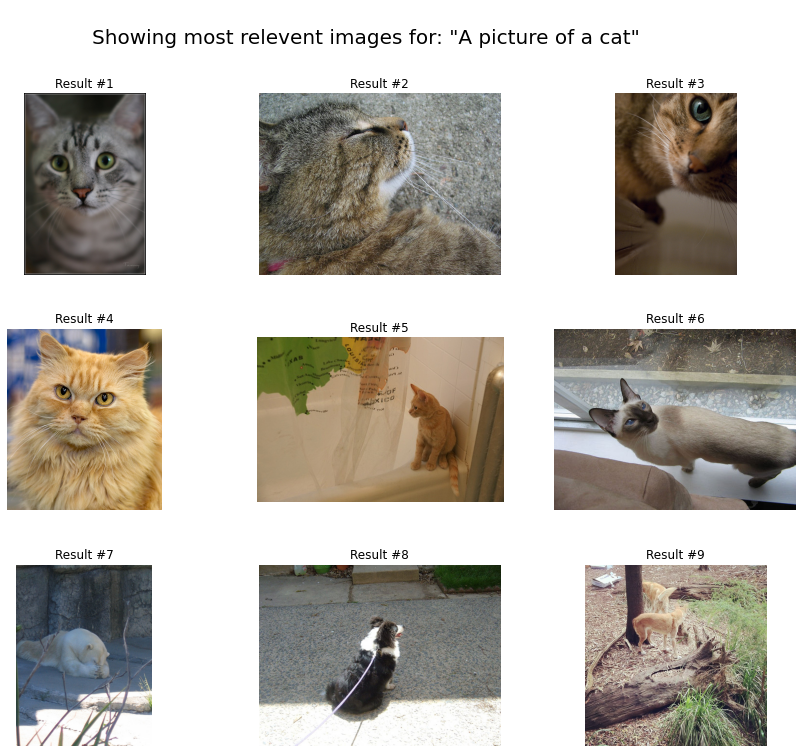

In [98]:
display_most_similar(similarities)